In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from time import time
import cv2

EPS = 1e-8

In [2]:
map_name = 'sparse_obstacles'
img = cv2.imread(map_name + '.png')
with open(map_name + '_lines.txt', 'r') as f:
    segments = np.array([[float(j) for j in line.split()] for line in f])

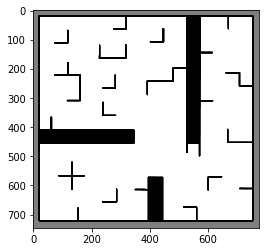

In [3]:
plt.imshow(img)

In [4]:
def make_vecs(xs, ys):
    '''
    Creates 2D numpy array from two 1D arrays.
    
    Args:
        xs (nx1 numpy array): x coordinates array
        ys (nx1 numpy array): y coordinates array
    
    Returns:
        vecs (nx2 numpy array): combined array
    '''
    return np.hstack((vert(xs), vert(ys)))


def make_3d_vecs(xs, ys):
    '''
    Creates 3D numpy array from two 2D arrays.
    
    Args:
        xs (nxm numpy array): x coordinates array
        ys (nxm numpy array): y coordinates array
    
    Returns:
        vecs (nxmx2 numpy array): combined array
    '''
    return np.dstack((xs, ys))


def compute_norms(vecs):
    '''
    Compute norm of 2D vectors.
        
    Args:
        vecs (nx2 numpy array): array with 2D vectors
    
    Returns:
        norms (nx1 numpy array): vector norms
    '''
    return np.sqrt(vecs[:,0]*vecs[:,0] + vecs[:,1]*vecs[:,1])


def vert(v):
    '''
    Transform v into vertical array.
    
    Args:
        v (numpy array): array to be transformed
    
    Returns:
        vertical (nx1 numpy array): transformed array
    '''
    return v.reshape((-1, 1))


def hor(v):
    '''
    Transform v into horizontal array.
    
    Args:
        v (numpy array): array to be transformed
    
    Returns:
        horizontal (1xn numpy array): transformed array
    '''
    return v.reshape((1, -1))


def are_parallel(seg_directs, directions):
    '''
    Checks if seg_directs and directions are parallel.
    
    Args:
        seg_directs (nx2 numpy array): segment directions computed by subtracting one end point 
            by the other directions (mx2 numpy array): direction vectors
    
    Returns:
        parallel (nxm numpy array): parallel[i,j] is True if segment direction i is parallel 
            to direction j
    '''
    norms = compute_norms(seg_directs)
    seg_directs = seg_directs / make_vecs(norms, norms)
    dx = hor(directions[:,0])
    dy = hor(directions[:,1])
    return (np.abs((vert(seg_directs[:,0])-dx) < EPS) & (np.abs(vert(seg_directs[:,1])-dy) < EPS)) | \
           (np.abs((vert(seg_directs[:,0])+dx) < EPS) & (np.abs(vert(seg_directs[:,1])+dy) < EPS))
    
    
def compute_intersections(pt, directions, segments):
    '''
    Compute all intersection points in each direction.
    
    Args:
        origin (tuple): x, y coordinates
        directions (mx2 numpy array): normalized directions
        segments (nx4 numpy array): segments are represented by (x1, y1, x2, y2), 
            where (x1, y1) and (x2, y2) are the end points
    
    Returns:
        valid (nxm numpy array): valid[i,j] is True if intersection between segment 
            i and direction j is valid
        intersections (nxmx2 numpy array): intersections[i,j,:] is the intersection point
            between segment i and direction j
    '''
    n = segments.shape[0]
    angles_n = directions.shape[0]
    px, py = pt
    ctheta = hor(directions[:,0])
    stheta = hor(directions[:,1])
    x1, y1, x2, y2 = vert(segments[:, 0]), vert(segments[:, 1]), vert(segments[:, 2]), vert(segments[:, 3])
    p1 = make_3d_vecs(np.repeat(x1, angles_n, axis=1), np.repeat(y1, angles_n, axis=1))
    p2 = make_3d_vecs(np.repeat(x2, angles_n, axis=1), np.repeat(y2, angles_n, axis=1))
    denom = (vert(x2 - x1) * stheta + vert(y1 - y2) * ctheta)
    s = (vert(px - x1) * stheta + vert(y1 - py) * ctheta) / denom
    r = (y1 + s * vert(y2 - y1) - py) / stheta
    use_x = (abs(ctheta) > abs(stheta)).flatten()
    r[:,use_x] = ((x1 + s * vert(x2 - x1) - px) / ctheta)[:,use_x]
    intersections = make_3d_vecs(px + r * ctheta, py + r * stheta)
    valid = np.repeat(True, n * angles_n).reshape(n, angles_n)
    
    # Check for parallel cases
    seg_directs = make_vecs(segments[:,2] - segments[:,0], segments[:,3] - segments[:,1])
    parallel_directs = are_parallel(seg_directs, directions)
    between1 = make_vecs(x1 - px, y1 - py)
    between2 = make_vecs(x2 - px, y2 - py)
    norms_between1 = compute_norms(between1)
    norms_between2 = compute_norms(between2)
    # p1 = pt
    in_p1 = vert(norms_between1 < EPS)
    idx = parallel_directs & in_p1
    intersections[idx, :] = p1[idx, :]
    # parallel
    not_collinear = (~are_parallel(between1, directions)) & (~in_p1)
    valid[parallel_directs & not_collinear] = False
    # pt = p1 or pt = p2
    collinear_p1 = (~not_collinear) & vert(norms_between1 < norms_between2)
    collinear_p2 = (~not_collinear) & vert(norms_between1 >= norms_between2)
    intersections[parallel_directs & collinear_p1,:] = p1[parallel_directs & collinear_p1,:]
    intersections[parallel_directs & collinear_p2,:] = p2[parallel_directs & collinear_p2,:]
    
    # Check validity
    not_valid = (np.abs(denom) < EPS) | (r < -EPS) | (s < -EPS) | (s > 1+EPS)
    valid[(~parallel_directs) & not_valid] = False

    return valid, intersections


def closest_intersections(origin, directions, segments):
    '''
    Find closest intersection point in each direction.
    
    Args:
        origin (tuple): x, y coordinates
        directions (mx2 numpy array): normalized directions
        segments (nx4 numpy array): segments are represented by (x1, y1, x2, y2), 
            where (x1, y1) and (x2, y2) are the end points
    
    Returns:
        closest (list): the returned list has one element for each direction. 
            The element is the closest intersection point in that direction. 
            If there is not intersection in that direction, the element is None.
    '''
    valid, intersections = compute_intersections(origin, directions, segments)
    closest = []
    for i in range(valid.shape[1]):
        valid_intersections = intersections[valid[:,i],i,:]
        if valid_intersections.shape[0] == 0:
            closest.append(None)
            continue
        dif = valid_intersections - origin
        dsq = dif[:,0]*dif[:,0] + dif[:,1]*dif[:,1]
        closest.append(valid_intersections[np.argmin(dsq),:])
    return closest
        

/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in multiply
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in multiply
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in less
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in greater


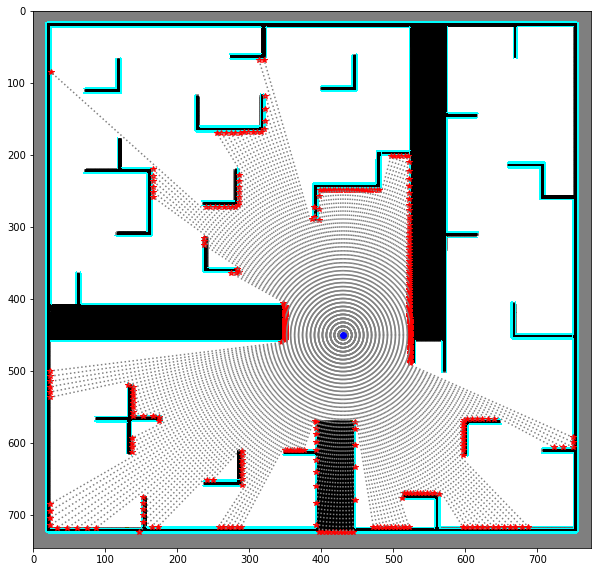

In [8]:
origin = (430, 450)

img_copy = img.copy()
# Draw segments
for seg in segments:
    cv2.line(img_copy, tuple(seg[:2].astype(int)), tuple(seg[2:4].astype(int)), (0, 255, 255))

# Make directions list
angles = [math.radians(i) for i in range(0, 361, 1)]
directions = np.array([(math.cos(i), math.sin(i)) for i in angles])
# Find closest intersections
intersections = closest_intersections(origin, directions, segments)
intersections = np.array([i for i in intersections if i is not None])

# Draw
plt.figure(figsize=(10,10))
plt.imshow(img_copy)
plt.plot(intersections[:,0], intersections[:,1], '*', c='r')
for i in range(intersections.shape[0]):
    plt.plot((origin[0], intersections[i,0]), (origin[1], intersections[i,1]), ':', c='gray')
plt.plot(origin[0], origin[1], 'ob')


In [9]:
# Measure time
TRIALS = 500
angles = [math.radians(i) for i in range(0, 361, 1)]
directions = np.array([(math.cos(i), math.sin(i)) for i in angles])

durations = []
for _ in range(TRIALS):
    # Random position
    origin = (random.randint(0, img.shape[1]), random.randint(0, img.shape[0]))
    t0 = time()
    intersections = closest_intersections(origin, directions, segments)
    durations.append(time() - t0)
durations = np.array(durations)
print('MEAN: {:.5f} ms, STD: {:.5f} ms'.format(durations.mean(), durations.std()))
print('MEAN: {:.2f} fps'.format(1 / durations.mean()))

/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in multiply
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in multiply
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in less
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in greater
/anaconda3/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:112: RuntimeW

MEAN: 0.01922 ms, STD: 0.00236 ms
MEAN: 52.03 fps
